# Logistic Regression Exoplanet Vetter

## Imports and directories

In [1]:
import sys, os
from tqdm import tqdm
import numpy as np
# import pandas as pd # to read CSV
from sklearn import model_selection, preprocessing # for multivariable linear regression
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.metrics as skm
import h5py
import gc
import pickle
import time
# for obj in gc.get_objects():   # Browse through ALL objects
#     if isinstance(obj, h5py.File):   # Just HDF5 files
#         try:
#             obj.close()
#         except:
#             pass # Was already closed

sectors = ["sector-{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

# Manually point to TICS folder which contains labels.tsv
TICS_dropbox = "/Users/hblim/Dropbox (MIT)/qlp-data/TICS"

# Manually point to TICS folder which has preprocessed lightcurves
TICS_drive   = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/updatedH5"

## Option 1: Import Old Data and Count existing files

In [10]:
  # Features:
  #   [0] astronet score
  #   [1] depth best ap - 1
  #   [2] depth best ap (global)
  #   [3] depth best ap + 1 or best ap
  #   [4] error best ap - 1
  #   [5] error best ap (global)
  #   [6] error best ap + 1
  # 
  #   [7] depth best ap - 1
  #   [8] depth best ap (local)
  #   [9] depth best ap + 1 or best ap
  #   [10] error best ap - 1
  #   [11] error best ap (local)
  #   [12] error best ap + 1
  # 
  #   [13] depth even
  #   [14] depth odd
  #   [15] error even
  #   [16] error odd

  #   [17] depth secondary
  #   [18] error seconday

  #   [19] label

In [3]:
# get all files that have lightcurves
filelist = []
for i,sector in enumerate(sectors):
    filelist += os.listdir(os.path.join(TICS_drive,sector,"preprocessed"))
filelist = list(set(filelist))
print(len(filelist),"lightcurve files")

145415 lightcurve files


In [5]:
labels_tsv = np.genfromtxt(os.path.join(TICS_dropbox,"labels.tsv"),skip_header = 3,usecols=(0),dtype='i8')

# get files from 
filelist = open(os.path.join(TICS_drive,"filelist.txt"),'r').readlines()
filelist = set([i.strip() for i in filelist])

labels_str = set([str(labels_tsv[i]) + '.h5' for i in range(len(labels_tsv))])
print("total files: ", len(filelist))
print("total planets: ", len(filelist.intersection(labels_str)))
print("total missing: ", len(labels_str - filelist.intersection(labels_str)))

missing = list(labels_str - filelist.intersection(labels_str))
fout = open(os.path.join(TICS_drive,"missing.txt"),'w')
for m in missing:
    fout.write(m + '\n')
fout.close()

total files:  134628
total planets:  800
total missing:  893


In [6]:
# Global folder paths
datapath  = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/"

# Manually include which sectors names to scan
sectors = ["sector-{}".format(i) for i in \
           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

data = np.zeros((0,20))
for i in range(len(sectors)):
    datatemp = np.load(os.path.join(datapath,sectors[i],'lcFeatures.npy'))
    data = np.append(data,datatemp,axis = 0)

In [9]:
n_planet = np.sum(data[:,-1] == 1)
n_nonplanet = np.sum(data[:,-1] == 0)
n_planet,n_nonplanet,n_planet / n_nonplanet

fdata = data[:,[0,1,2,3,7,8,9,13,14,17,19]]
X = fdata[:,0:-1]
y = fdata[:,-1] * 2 - 1

NameError: name 'data' is not defined

## Options 2: Import New Data

In [2]:
def readPickle(filepath):
    assert os.path.exists(filepath)

    with open(filepath,'rb') as f: data = pickle.load(f)

    nfiles = len(data)

    #views
    localviews = np.zeros((nfiles,3,61))
    globalviews = np.zeros((nfiles,3,201))

    std_depths     = np.zeros((nfiles,2))
    true_depths    = np.zeros((nfiles,6))
    depth_errors   = np.zeros((nfiles,6))
    astronet_score = np.zeros((nfiles,1))
    stellar_radii  = np.zeros((nfiles,1))
    magnitudes     = np.zeros((nfiles, 1))

    other_stuff    = np.zeros((nfiles,3))


    # Labels
    labels = np.zeros((nfiles,))

    for i,file in enumerate(data):
        
        stdcut = (np.std(file['LocalDepths']) < 1) and (np.std(file['GlobalDepths']) < 1)
        non_zero_depths = ((np.sum(file['LocalDepths'] == 0) + np.sum(file['GlobalDepths'] == 0)) == 0)
        no_nans = np.sum(np.isnan(file['LocalView'])) + np.sum(np.isnan(file['GlobalView'])) == 0

        if no_nans and non_zero_depths and stdcut:
            localviews[i] = file['LocalView']
            globalviews[i] = file['GlobalView']
            labels[i] = file['label']

            astronet_score[i] = np.array([file['AstroNetScore']])
            std_depths[i]     = np.array([np.std(file['LocalDepths']),np.std(file['GlobalDepths'])])
            true_depths[i]    = np.hstack([file['LocalDepths'],file['GlobalDepths']])
            depth_errors[i]    = np.hstack([file['LocalDepthErrors'],file['GlobalDepthErrors']])
            stellar_radii[i]  = np.array([file['StellarParams']['rad']])
            magnitudes[i]     = np.array(file['StellarParams']['tmag'])

            other_stuff[i]    = np.append(file['EvenOddDepths'],file['SecondaryDepth'])


    return labels, localviews, globalviews, std_depths, true_depths, depth_errors, astronet_score, stellar_radii, magnitudes, other_stuff

In [3]:
def loadSortedData(pickleDir, sectors, verbose=True):
    std_depths = np.zeros((0,2))
    true_depths = np.zeros((0,6))
    depth_errors = np.zeros((0,6))
    astronets = np.zeros((0,1))
    stellar_radii = np.zeros((0,1))
    all_mag    = np.zeros((0,1))

    all_localviews = np.zeros((0,3,61))
    all_globalviews = np.zeros((0,3,201))
    all_labels = np.zeros((0,))

    all_other = np.zeros((0,3))

    # append with data from each sector
    for sector in tqdm(sectors):
        
        filepath = pickleDir + sector + '.pickle'
        labels, localviews, globalviews, std_depth, true_depth, depth_error, astronet_score, stellar_rad, magnitude, other_stuff = readPickle(filepath)

        std_depths    = np.append(std_depths, std_depth,axis=0)
        true_depths   = np.append(true_depths,true_depth,axis=0)
        depth_errors  = np.append(depth_errors, depth_error, axis=0)
        astronets     = np.append(astronets, astronet_score, axis = 0)
        stellar_radii = np.append(stellar_radii, stellar_rad , axis = 0)
        all_mag       = np.append(all_mag, magnitude, axis=0)

        all_localviews = np.append(all_localviews, localviews,axis=0)
        all_globalviews = np.append(all_globalviews, globalviews,axis=0)
        all_labels = np.append(all_labels,labels)

        all_other = np.append(all_other, other_stuff, axis=0)

    if verbose:
        print("X_global.shape = ", all_globalviews.shape)
        print("X_local.shape  = ", all_localviews.shape)
        print("X_depths.shape = ", true_depths.shape)
        print("y.shape        = ", all_labels.shape)

    return all_labels, all_localviews, all_globalviews, true_depths, depth_errors, std_depths, astronets, stellar_radii, all_mag, all_other

In [25]:
def addToDataMatrix(X, addon):
    n = np.shape(X)[0]
    ncols = np.prod(np.shape(addon)[1:])
    X = np.append(X, addon.reshape(n,ncols), axis=1)
    return X

def genDataMatrix(y, *features):
    n = len(y)
    X = np.zeros((n,0))
    for feat in features:
        X = addToDataMatrix(X, feat)
    return X, y

pickleDir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/"

sectors = [f'sector-{i}' for i in range(1,22)]
labels, localviews, globalviews, depths, depth_err, std_depths, astronets, srad, tmag , other= loadSortedData(pickleDir, sectors)
eod = other[:,:2]
eostd = np.std(eod,1,keepdims=True)


# X, y = genDataMatrix(labels, std_depths, astronets, tmag, depths, other, eostd)

X, y = genDataMatrix(labels, std_depths, astronets, tmag)

100%|██████████| 21/21 [01:13<00:00,  3.52s/it]

X_global.shape =  (248392, 3, 201)
X_local.shape  =  (248392, 3, 61)
X_depths.shape =  (248392, 6)
y.shape        =  (248392,)


In [28]:
y = y.astype('int64')
X.shape, y.shape

((248392, 4), (248392,))

In [4]:
# verbose = 1
# pickle_dir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/"

# std_depths = np.zeros((0,2))
# true_depths = np.zeros((0,6))
# astronets = np.zeros((0,1))
# stellar_radii = np.zeros((0,1))

# all_localviews = np.zeros((0,3,61))
# all_globalviews = np.zeros((0,3,201))
# all_labels = np.zeros((0,),dtype=int)

# # append with data from each sector
# for sector in range(1,22):
    
#     filepath = pickle_dir + 'sector-{}.pickle'.format(sector)
#     print(filepath)
#     localviews, globalviews, std_depth, true_depth, astronet_score, stellar_rad, labels = read_pickle(filepath)
    
#     std_depths = np.append(std_depths, std_depth,axis=0)
#     true_depths = np.append(true_depths,true_depth,axis=0)
#     astronets = np.append(astronets, astronet_score, axis = 0)
#     stellar_radii = np.append(stellar_radii, stellar_rad , axis = 0)
    
    
#     all_localviews = np.append(all_localviews, localviews,axis=0)
#     all_globalviews = np.append(all_globalviews, globalviews,axis=0)
#     all_labels = np.append(all_labels,labels)

# if verbose:
#     print("X_global.shape = ", all_globalviews.shape)
#     print("X_local.shape  = ", all_localviews.shape)
#     print("X_depths.shape = ", true_depths.shape)
#     print("y.shape        = ", all_labels.shape)

/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-1.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-2.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-3.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-4.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-5.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-6.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-7.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-8.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-9.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-10.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-11.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-12.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-13.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-14.pickle
/Users/hblim/Dr

In [20]:
# verbose = 1
# ntotal = len(all_labels)
# X = np.zeros((ntotal,0))
# # X = np.append(X, all_localviews.reshape((ntotal,3*61)),axis=1)
# # X = np.append(X, all_globalviews.reshape((ntotal,3*201)),axis=1)
# X = np.append(X, std_depths.reshape((ntotal,2)),axis=1)
# X = np.append(X, astronets.reshape((ntotal,1)),axis=1)
# # X = np.append(X, true_depths.reshape((ntotal,6)),axis=1)
# X = np.append(X, all_labels.reshape((ntotal,1)),axis=1)

# # downsample majority class
# PCs = all_labels == 1
# nonPCs = all_labels == 0
# X_PC = X[PCs]
# X_nPC = X[nonPCs]

# np.random.shuffle(X_nPC)
# # X_nPC = X_nPC[0:int(np.sum(nonPCs) / 10)]
# # X_nPC = X_nPC[0:int(np.sum(PCs)) ]

# Xfil = np.vstack([X_PC,X_nPC])
# np.random.shuffle(Xfil)


# X = Xfil[:,:-1]
# y = Xfil[:,-1].astype(int)
# # if verbose: print("X.shape = ", X.shape)
y = y.astype('int64')
y.dtype

dtype('int64')

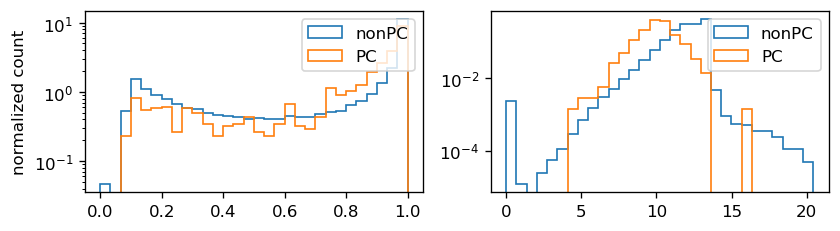

In [58]:
normed = True
PCs = (y == 1)
nonPCs = (y == 0)

sc = preprocessing.StandardScaler()
Xp = sc.fit_transform(X)

localstds = X[:,2] 
globalstds = X[:,3] 

fig, (ax1,ax2) = plt.subplots(ncols = 2,figsize = (8,2),dpi=120)
plt.sca(ax1)
n, bins, p = plt.hist(localstds[nonPCs],30,density=True,label='nonPC',histtype='step');
plt.hist(localstds[PCs],bins,density=True,label='PC',histtype='step');
plt.yscale('log')

# plt.xlabel(r'$\sigma_{\rm ap,local}$')
plt.ylabel(r'normalized count')
plt.legend()

plt.sca(ax2)
n, bins, p = plt.hist(globalstds[nonPCs],30,density=True,label='nonPC',histtype='step');
plt.hist(globalstds[PCs],bins,density=True,label='PC',histtype='step');

plt.yscale('log')

# plt.xlabel(r'$\sigma_{\rm ap,global}$')
plt.legend();

## Use all data columns

Data and labels $X$ and $y$ should be defined

In [ ]:
from sklearn.utils import class_weight as cw

# Xnorm = X[:,0:4]

kfold_score = [] # RMSE per case
kfold_predict = [] # predict class

n_cases = (X.shape)[0]
nfolds = 5

precision_recall = []

kfold = model_selection.StratifiedKFold(n_splits = nfolds,shuffle=True)
i = 0
t0 = time.time()


# scale training data
# sc = preprocessing.StandardScaler()
# Xp = sc.fit_transform(X)

# Xp = np.copy(X)
Xp[:,3] /= np.mean(X[:,3])
yp = np.copy(y)

# np.random.shuffle(Xp)
# np.random.shuffle(yp)
# Xp = X[::5,:]
# yp = yp[::5]
weightss = cw.compute_class_weight('balanced',[0,1],y)
print(Xp.shape)


for train_index, test_index in kfold.split(Xp,yp):

    t0 = time.time()
    
    # split into test, training
    X_train, X_test = Xp[train_index], Xp[test_index]
    y_train, y_test = yp[train_index], yp[test_index]
    
    # regress
    reg = lm.LogisticRegression( \
                                penalty='l2',
                                fit_intercept=True,
                                C = 1.0,
                                solver='sag',
                                tol = 1e-3, #class_weight = 'balanced',
                                max_iter = 1000,
                                warm_start=True, n_jobs=-1
                               )
    
    reg.fit(X_train,y_train)

    # scale test data and predict
#     X_test_sc = scaler.transform(X_test)
    prediction = reg.predict(X_test)
    probabilities = reg.predict_proba(X_test)
    kfold_predict.append(prediction)
    
    precision_recall.append(skm.precision_recall_curve(np.array(y_test),probabilities[:,1],pos_label=1))

    
    print("Fold #{}: {:.4f}".format(i,time.time() -t0))
    i += 1
#     if i == 1: break

(248392, 4)
Fold #0: 12.7340
Fold #1: 11.3030
Fold #2: 10.6916


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


Text(0.5, 0, 'Recall')

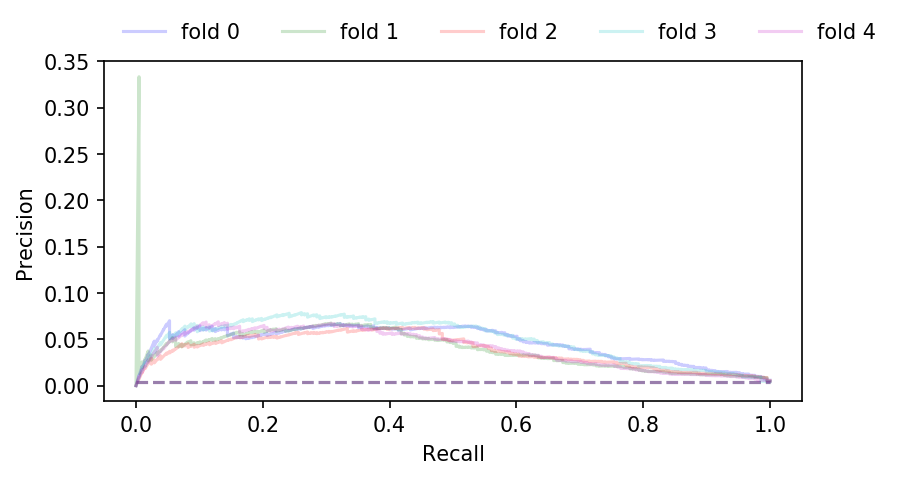

In [101]:
plt.figure(figsize = (6,3),dpi = 150)

xp = np.linspace(0.01,.99,1000)
yp = np.zeros((nfolds,len(xp)))

colors = ['b','g','r','c','m']

for i in range(len(precision_recall)):
    noskill = (y == 1).sum() / len(y) 
    plt.plot(precision_recall[i][1][:-1],precision_recall[i][0][:-1],color=colors[i],alpha=0.2,label="fold {}".format(i))
    plt.plot([0,1],[noskill,noskill],color=colors[i],linestyle='--',alpha=0.2)
    yp[i] = np.interp(xp,precision_recall[i][1][-1:0:-1],precision_recall[i][0][-1:0:-1])
    print(yp[i].shape)

# average
# plt.plot(xp,np.mean(yp,axis=0),'k-',label='k-fold average')

plt.legend(frameon=False,ncol=nfolds,bbox_to_anchor=(0,1),loc='lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
# plt.ylim([0,.4])

In [91]:
y_test.sum()

40